In [2]:
import json
from __future__ import print_function 
import numpy as np 
import matplotlib.pyplot as plt 
import matplotlib as mpl 
import datetime as dt

mpl.rcParams['savefig.dpi'] = 100 
mpl.rcParams['figure.dpi'] = 100
mpl.rcParams.update({'font.size': 40})

%config InlineBackend.figure_format = 'retina' 
%matplotlib inline

import matplotlib.dates as mdates
import pandas as pd
import numpy as np

# Analyzing Rent Prices vs. Taxi Trips

In [3]:
# taxi id - zillow id mapping
tz_map = json.load(open('./taxi_zillow_mapping.json'))
tz_map[4]

{u'id': 5,
 u'name': u'Prospect Park',
 u'taxi_ids': [190],
 u'zillow_ids': [403161]}

In [5]:
# Load the yellow taxi analysis
yellow = pd.read_csv('./yellow_daily.csv', index_col=None, header=None)
yellow.columns = ['location_id', 'event', 'year', 'month', 'day',
                 'passengers', 'distance', 'fare', 'count']
yellow[:10]

,location_id,event,year,month,day,passengers,distance,fare,count
0,1,DO,2013,1,1,1934,15863.27,78576.59,958
1,1,DO,2013,1,2,1692,14440.40,71460.05,872
2,1,DO,2013,1,3,1167,9807.88,47847.31,580
3,1,DO,2013,1,4,910,7760.85,39264.87,457
4,1,DO,2013,1,5,1028,9029.48,44363.66,526
5,1,DO,2013,1,6,962,8768.42,43650.40,514
6,1,DO,2013,1,7,670,6853.39,34790.31,412
7,1,DO,2013,1,8,598,5988.66,31528.43,378
8,1,DO,2013,1,9,700,6609.62,34114.78,399
9,1,DO,2013,1,10,715,7452.30,39019.75,447


# Adjust Zillow Rent Prices With Inflation

In [100]:
# Load zillow rent prices
# DL from: http://files.zillowstatic.com/research/public/Neighborhood/Neighborhood_MedianRentalPrice_1Bedroom.csv
zillow = pd.read_csv('./Neighborhood_MedianRentalPricePerSqft_1Bedroom.csv')
z = zillow
zillow = zillow[(z['City'] == 'New York') & (z['State'] == 'NY')]
early_cols = ['{}-{:02}'.format(year, month) for year in [2010, 2011, 2012, 2017] for month in range(1,13)]
early_cols = [c for c in early_cols if c in zillow.columns]
zillow = zillow.drop(early_cols, axis=1)
zillow.describe()

,SizeRank,2013-01,2013-02,2013-03,2013-04,2013-05,2013-06,2013-07,2013-08,2013-09,...,2016-03,2016-04,2016-05,2016-06,2016-07,2016-08,2016-09,2016-10,2016-11,2016-12
count,19.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,3.000000,...,19.000000,19.000000,19.000000,19.000000,19.000000,19.000000,19.000000,19.000000,19.000000,19.000000
mean,50.736842,3.094882,3.123517,3.250494,3.210113,3.216374,3.246604,3.251540,3.248933,2.900556,...,4.473591,4.465208,4.475902,4.437653,4.386507,4.464198,4.442000,4.449526,4.432118,4.391468
std,32.115836,0.970549,0.979657,1.239634,1.239954,1.109969,1.159236,1.161047,1.138597,0.976754,...,1.278668,1.259356,1.249509,1.265520,1.216247,1.245179,1.219687,1.267218,1.220385,1.253348
min,3.000000,2.408601,2.430795,2.373941,2.333333,2.431507,2.426901,2.430556,2.443824,2.199762,...,2.333333,2.368421,2.433036,2.279202,2.359944,2.391304,2.406250,2.352564,2.380074,2.266667
25%,21.000000,2.751741,2.777156,2.812217,2.771723,2.823940,2.836752,2.841048,2.846378,2.342697,...,3.621119,3.537359,3.582564,3.560613,3.508600,3.528201,3.541942,3.547849,3.541542,3.454788
50%,55.000000,3.094882,3.123517,3.250494,3.210113,3.216374,3.246604,3.251540,3.248933,2.485632,...,5.062242,5.064961,5.054528,5.111111,4.953775,5.108239,5.000000,5.079365,4.930663,4.920461
75%,77.500000,3.438023,3.469878,3.688771,3.648503,3.608807,3.656456,3.662032,3.651488,3.250952,...,5.146103,5.174442,5.160548,5.185311,5.160059,5.198850,5.152233,5.141870,5.159176,5.124448
max,109.000000,3.781163,3.816239,4.127047,4.086892,4.001241,4.066308,4.072524,4.054043,4.016272,...,6.314516,6.246564,6.165897,6.096774,5.877863,6.171384,6.092050,6.067005,6.096774,6.055944


In [101]:
zillow_cols_to_idx = {z: i + 1 for i, z in enumerate(zillow.columns)}
zillow[:3]

,RegionName,City,State,Metro,CountyName,SizeRank,2013-01,2013-02,2013-03,2013-04,...,2016-03,2016-04,2016-05,2016-06,2016-07,2016-08,2016-09,2016-10,2016-11,2016-12
2,Upper West Side,New York,NY,New York,New York,3,NaN,NaN,NaN,NaN,...,5.062242,5.075724,5.049638,5.000000,4.599479,5.000000,5.000000,4.923077,4.919786,4.920461
9,Harlem,New York,NY,New York,New York,10,NaN,NaN,NaN,NaN,...,2.995000,2.884774,2.926421,2.894024,2.885621,2.843750,2.952305,2.948359,2.934936,2.836277
10,East Harlem,New York,NY,New York,New York,11,NaN,NaN,NaN,NaN,...,5.169867,5.169867,5.169867,5.185213,5.176397,5.169867,5.169867,5.246423,5.195630,5.443726


In [24]:
# Inflation data
inflation = pd.read_csv('cpi_inflation.csv', index_col='Year')
print(inflation.ix[2015]['Jul'])
inflation

238.212


,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
Year,,,,,,,,,,,,
2013,225.060,225.584,225.745,226.309,227.011,227.330,227.555,227.909,228.343,228.576,229.120,229.626
2014,230.545,231.141,232.096,232.040,232.849,233.092,233.610,233.899,234.177,234.616,235.004,235.456
2015,235.791,236.295,236.586,237.171,237.285,237.768,238.212,238.635,239.133,239.535,239.989,240.303
2016,240.752,241.310,241.641,242.202,242.919,243.459,244.048,244.804,245.595,246.380,246.947,247.616


In [60]:
# Create an array with zillow prices adjusted by inflation.
zillow_inf_adjust = zillow.copy()
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
standard = inflation.ix[2016]['Dec']
for year in range(2013, 2017):
    for month in range(1, 13):
        colname = '{}-{:02}'.format(year, month)
        col = zillow_inf_adjust[colname]
        col = standard / inflation.ix[year][months[month - 1]] * col
        zillow_inf_adjust[colname] = col

In [61]:
zillow.to_csv('zillow_ny.csv')
zillow_inf_adjust.to_csv('zillow_inf_adjust.csv')

In [146]:
# What is the Zillow Neighborhood ID?
zillow_shape = json.load(open('ZillowNeighborhoods-NY_mapshaper.json'))

In [179]:
zid = 0
name = 'Battery Park'
for z in zillow_shape['features']:
    prop = z['properties']
    if name in prop['Name']:
        zid = int(prop['RegionID'])
        print(prop)

tid = 0
for m in tz_map:
    if zid in m['zillow_ids']:
        tid = m['taxi_ids'][0]
        print(m)
        break

{u'County': u'New York', u'City': u'New York', u'State': u'NY', u'RegionID': u'272869', u'Name': u'Battery Park'}
{u'zillow_ids': [272869], u'id': 91, u'name': u'Battery Park City', u'taxi_ids': [13]}


In [180]:
# Get taxi pickups
taxis = yellow[yellow['location_id'] == tid]
taxis = taxis[taxis['event'] == 'DO']
taxis = taxis[taxis['year'] < 2017]
taxis = taxis[['year', 'month', 'count']]
taxis = taxis.groupby(by=['year', 'month']).mean()
taxis

count
year month             
2013 1      4246.129032
     2      4416.678571
     3      4483.612903
     4      4675.400000
     5      4432.838710
     6      4631.466667
     7      4308.258065
     8      3763.548387
     9      4288.833333
     10     4495.451613
     11     4198.066667
     12     3849.709677
2014 1      3827.709677
     2      3896.107143
     3      4277.387097
     4      4313.466667
     5      4238.612903
     6      4365.400000
     7      4062.032258
     8      3807.548387
     9      4132.833333
     10     4258.935484
     11     3906.700000
     12     3846.290323
2015 1      3532.774194
     2      3881.678571
     3      3908.967742
     4      4197.566667
     5      4058.677419
     6      4252.866667
     7      4011.806452
     8      3779.677419
     9      3741.566667
     10     4025.774194
     11     3723.900000
     12     3755.548387
2016 1      3314.516129
     2      3715.655172
     3      3914.967742
     4      4090.033333
     5      3921.290323
     6      4027.766667
     7      3616.870968
     8      3432.903226
     9      3547.733333
     10     3626.580645
     11     3401.300000
     12     3345.806452

Battery Park


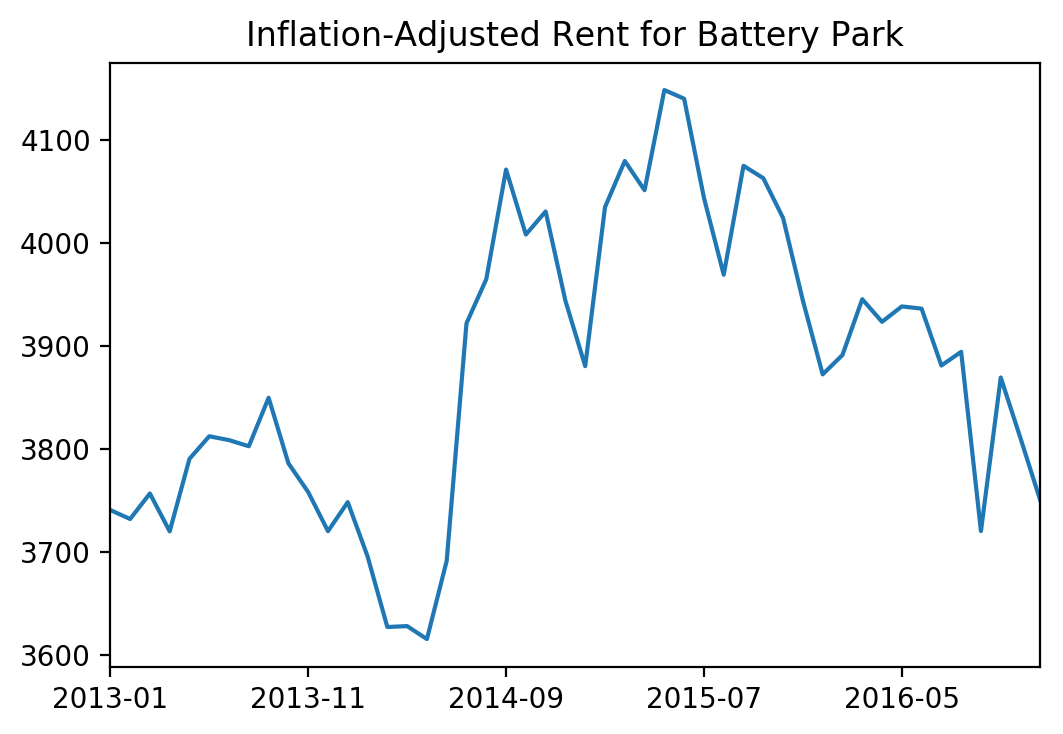

In [182]:
# Get one of the areas' columns
z = zillow_inf_adjust
print(name)
loc = z[z['RegionName'] == name]
rents = loc.drop(['RegionName', 'City', 'State', 'Metro', 'CountyName', 'SizeRank'], axis=1).T
x = plt.plot()
ax = rents.plot(ax=plt.gca(), title='Inflation-Adjusted Rent for ' + name, legend=False)
#ax = taxis.plot(ax=plt.gca(), legend=False)

plt.show()

(48, 1)
(48, 1)


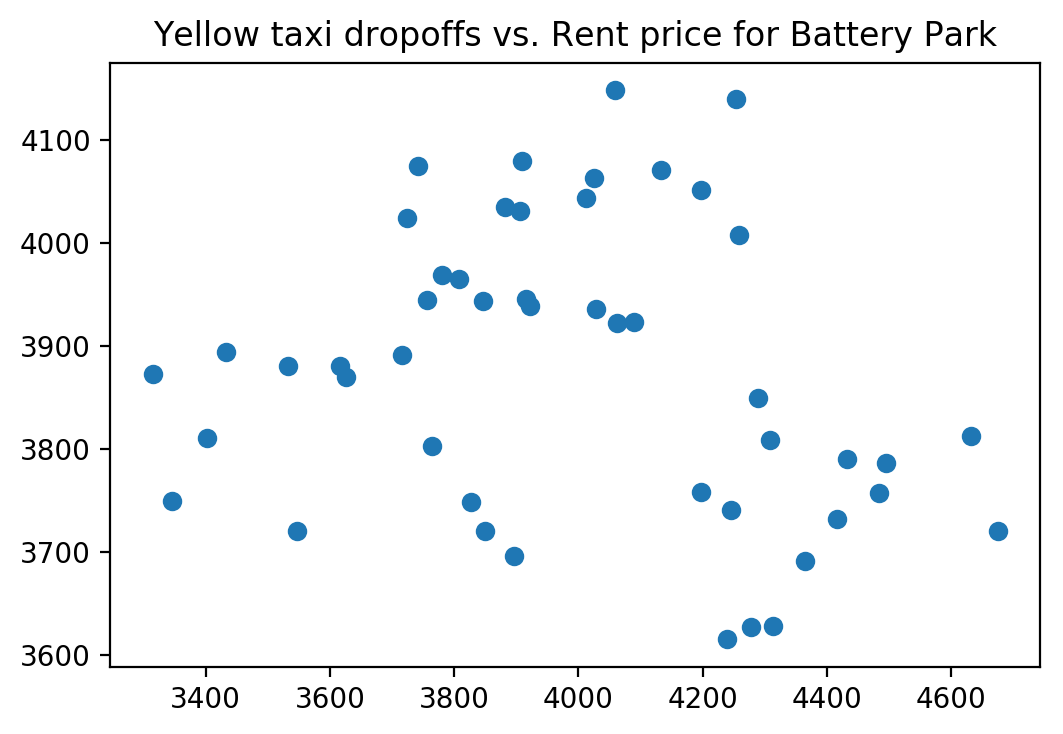

In [183]:
t_array = taxis.as_matrix()
z_array = rents.as_matrix()
print(t_array.shape)
print(z_array.shape)
plt.figure()
plt.scatter(t_array, z_array)
plt.title('Yellow taxi dropoffs vs. Rent price for ' + name)
plt.show()